In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix#, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [2]:
df= pd.read_csv("/content/warn_info.csv")

In [3]:
df1= df.copy()

In [4]:
df1

,static_text,log_level,preprocessed_text
0,No serialized RegionInfo in,warn,serial regioninfo
1,Added * regions to meta.,info,ad region meta
2,Updated * in hbase:meta,info,updat hbase meta
3,Deleted table | state from META,info,delet tabl state meta
4,Updated row * with server=,info,updat row
...,...,...,...
7653,caught an interrupted exception when waiting w...,warn,caught interrupt except wait close ticker thread
7654,not executing watch [*] on this scheduler beca...,info,execut watch schedul paus
7655,SpnegoClient with userPrincipalName : *,info,spnegocli userprincipalnam
7656,SimpleKdcLdapServer started.,info,simplekdcldapserv start


In [5]:
df1['log_level'].value_counts()

info    3903
warn    3755
Name: log_level, dtype: int64

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
df1['preprocessed_text'].fillna('', inplace=True)
df1 = df1.dropna(subset=['preprocessed_text'])

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
# Feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df1['preprocessed_text'])

In [10]:
# Label encoding
df1['log_level'] = df1['log_level'].map({'info': 0, 'warn': 1})
y = df['log_level']

In [11]:
df1

,static_text,log_level,preprocessed_text
0,No serialized RegionInfo in,1,serial regioninfo
1,Added * regions to meta.,0,ad region meta
2,Updated * in hbase:meta,0,updat hbase meta
3,Deleted table | state from META,0,delet tabl state meta
4,Updated row * with server=,0,updat row
...,...,...,...
7653,caught an interrupted exception when waiting w...,1,caught interrupt except wait close ticker thread
7654,not executing watch [*] on this scheduler beca...,0,execut watch schedul paus
7655,SpnegoClient with userPrincipalName : *,0,spnegocli userprincipalnam
7656,SimpleKdcLdapServer started.,0,simplekdcldapserv start


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# Split the data into training (80%), validation (10%), and testing (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print('Train sets:')
print(X_train.shape)
print(y_train.shape)

print('Validation sets:')
print(X_val.shape)
print(y_val.shape)

print('Test sets:')
print(X_test.shape)
print(y_test.shape)

Train sets:
(6126, 2697)
(6126,)
Validation sets:
(766, 2697)
(766,)
Test sets:
(766, 2697)
(766,)


# ***Class-Imabalance***

In [14]:
# Check the distribution of classes before SMOTE
print("Distribution of classes in the original training set:")
print(pd.Series(y_train).value_counts())

Distribution of classes in the original training set:
info    3103
warn    3023
Name: log_level, dtype: int64


In [15]:
# Apply SMOTE for balancing
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [16]:
# Check the distribution of classes after SMOTE
print("Distribution of classes in the training set after SMOTEENN:")
print(pd.Series(y_resampled).value_counts())

Distribution of classes in the training set after SMOTEENN:
info    3103
warn    3103
Name: log_level, dtype: int64


# ***Hyper-parameter tunning***

In [17]:
# Hyper-parameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [20, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

## **Model: RF**

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
model=RandomForestClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_resampled, y_resampled)
# Get the best parameters from the grid search
best_params = grid_search.best_params_
#model.fit(X_resampled, y_resampled)


In [20]:
# Train the model with the best parameters
best_model = RandomForestClassifier(random_state=42, **best_params)
best_model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

Validation Set Results:
Accuracy: 0.8381201044386423
              precision    recall  f1-score   support

        info       0.85      0.84      0.84       398
        warn       0.83      0.84      0.83       368

    accuracy                           0.84       766
   macro avg       0.84      0.84      0.84       766
weighted avg       0.84      0.84      0.84       766

MCC: 0.6760250856981291
[[333  65]
 [ 59 309]]


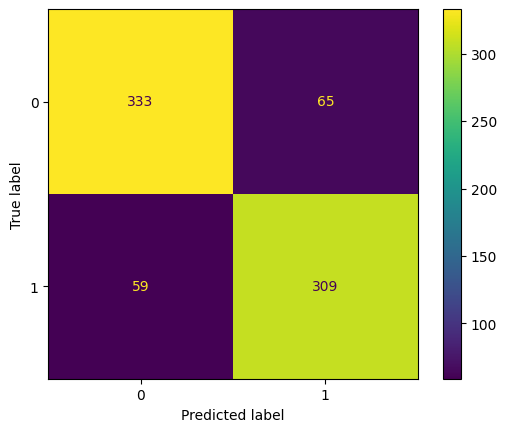

In [21]:
# Evaluate the model on the validation set
y_val_pred = best_model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
report_val = classification_report(y_val, y_val_pred)
mcc_val = matthews_corrcoef(y_val, y_val_pred)
conf_matrix_val = confusion_matrix(y_val, y_val_pred)

print("Validation Set Results:")
print(f"Accuracy: {accuracy_val}")
print(report_val)
print(f"MCC: {mcc_val}")
print(conf_matrix_val)

import matplotlib.pyplot as plt
cm = confusion_matrix(y_val, y_val_pred)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
cmd_obj.plot()

plt.show()

Test Set Results:
Accuracy: 0.8133159268929504
              precision    recall  f1-score   support

        info       0.82      0.83      0.82       402
        warn       0.81      0.80      0.80       364

    accuracy                           0.81       766
   macro avg       0.81      0.81      0.81       766
weighted avg       0.81      0.81      0.81       766

MCC: 0.6255841774321014
[[332  70]
 [ 73 291]]


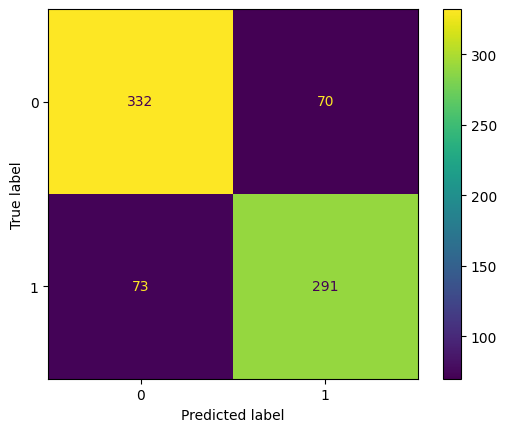

In [22]:
# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
report_test = classification_report(y_test, y_test_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
conf_matrix_val = confusion_matrix(y_test, y_test_pred)


print("Test Set Results:")
print(f"Accuracy: {accuracy_test}")
print(report_test)
print(f"MCC: {mcc_test}")
print(conf_matrix_val)

import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_test_pred)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
cmd_obj.plot()

plt.show()

In [23]:
# Random Forest Model
print("Random Forest Model Results:")
y_rf_pred = best_model.predict(X_test)
incorrect_rf_indices = y_test != y_rf_pred
correct_rf_indices = y_test == y_rf_pred

incorrect_rf_texts = df1.loc[y_test.index[incorrect_rf_indices], 'preprocessed_text']
true_rf_labels = y_test[incorrect_rf_indices]
predicted_rf_labels = y_rf_pred[incorrect_rf_indices]

print("\nRecords where Random Forest model failed to predict the labels:")
for idx, text, true_label, pred_label in zip(incorrect_rf_texts.index, incorrect_rf_texts, true_rf_labels, predicted_rf_labels):
    print(f"Index: {idx}, Text: {text}, True Label: {true_label}, Predicted Label: {pred_label}")

Random Forest Model Results:

Records where Random Forest model failed to predict the labels:
Index: 2206, Text: fail delet, True Label: info, Predicted Label: warn
Index: 376, Text: server hold hbase meta right, True Label: warn, Predicted Label: info
Index: 5770, Text: fail creat channel due, True Label: info, Predicted Label: warn
Index: 2276, Text: hdf region dir alreadi sidelin, True Label: warn, Predicted Label: info
Index: 3106, Text: empti messag, True Label: info, Predicted Label: warn
Index: 960, Text: old locat current hbase meta locat set locat null, True Label: info, Predicted Label: warn
Index: 7373, Text: exist basic licens expir basic licens longer licens old licens new licens, True Label: info, Predicted Label: warn
Index: 3605, Text: clean activ sstabl, True Label: warn, Predicted Label: info
Index: 3298, Text: support implement, True Label: warn, Predicted Label: info
Index: 6824, Text: request next learner master longer valid, True Label: warn, Predicted Label: info

In [25]:
    # Identify indices where predictions are incorrect
    incorrect_indices = y_test != y_test_pred

    # Extract the original texts and corresponding true labels
    incorrect_texts = df.loc[y_test.index[incorrect_indices], 'preprocessed_text']
    true_labels = y_test[incorrect_indices]
    predicted_labels = y_test_pred[incorrect_indices]

    # Print the records where the model failed to predict the labels
    print(f"\nRecords where {best_model} failed to predict labels:")
    for idx, text, true_label, pred_label in zip(incorrect_texts.index, incorrect_texts, true_labels, predicted_labels):
        print(f"Index: {idx}")
        print(f"True Labels: {true_label}")
        print(f"Predicted Labels: {pred_label}")
        print(f"Text: {text}\n")


Records where RandomForestClassifier(random_state=42) failed to predict labels:
Index: 2206
True Labels: info
Predicted Labels: warn
Text: fail delet

Index: 376
True Labels: warn
Predicted Labels: info
Text: server hold hbase meta right

Index: 5770
True Labels: info
Predicted Labels: warn
Text: fail creat channel due

Index: 2276
True Labels: warn
Predicted Labels: info
Text: hdf region dir alreadi sidelin

Index: 3106
True Labels: info
Predicted Labels: warn
Text: empti messag

Index: 960
True Labels: info
Predicted Labels: warn
Text: old locat current hbase meta locat set locat null

Index: 7373
True Labels: info
Predicted Labels: warn
Text: exist basic licens expir basic licens longer licens old licens new licens

Index: 3605
True Labels: warn
Predicted Labels: info
Text: clean activ sstabl

Index: 3298
True Labels: warn
Predicted Labels: info
Text: support implement

Index: 6824
True Labels: warn
Predicted Labels: info
Text: request next learner master longer valid

Index: 199
T

In [26]:
correct_rf_texts = df1.loc[y_test.index[correct_rf_indices], 'preprocessed_text']
correct_true_rf_labels = y_test[correct_rf_indices]
correct_predicted_rf_labels = y_rf_pred[correct_rf_indices]

print("\nRecords where Random Forest model predicted the labels correctly:")
for idx, text, true_label, pred_label in zip(correct_rf_texts.index, correct_rf_texts, correct_true_rf_labels, correct_predicted_rf_labels):
    print(f"Index: {idx}, Text: {text}, True Label: {true_label}, Predicted Label: {pred_label}")


Records where Random Forest model predicted the labels correctly:
Index: 2968, Text: use batch client set run threshold, True Label: info, Predicted Label: info
Index: 7419, Text: data frame transform encount except, True Label: warn, Predicted Label: warn
Index: 3049, Text: error resourc string found, True Label: warn, Predicted Label: warn
Index: 625, Text: remov empti, True Label: info, Predicted Label: info
Index: 6931, Text: test process use port, True Label: info, Predicted Label: info
Index: 4041, Text: index build complet, True Label: info, Predicted Label: info
Index: 4371, Text: fail releas action, True Label: warn, Predicted Label: warn
Index: 14, Text: fail get ip address byte, True Label: warn, Predicted Label: warn
Index: 5113, Text: jobmanagerrunn alreadi shutdown, True Label: info, Predicted Label: info
Index: 4520, Text: commit offset kafka take longer checkpoint interv skip commit previou offset newer complet checkpoint offset avail compromis flink checkpoint integr,

In [27]:
    # Identify indices where predictions are incorrect
    incorrect_indices = y_test != y_test_pred

    # Extract the original texts and corresponding true labels
    incorrect_texts = df.loc[y_test.index[incorrect_indices], 'preprocessed_text']
    true_labels = y_test[incorrect_indices]
    predicted_labels = y_test_pred[incorrect_indices]

    # Print the records where the model failed to predict the labels
    print(f"\nRecords where {best_model} failed to predict labels:")
    for idx, text, true_label, pred_label in zip(incorrect_texts.index, incorrect_texts, true_labels, predicted_labels):
        print(f"Index: {idx}")
        print(f"True Labels: {true_label}")
        print(f"Predicted Labels: {pred_label}")
        print(f"Text: {text}\n")


Records where RandomForestClassifier(random_state=42) failed to predict labels:
Index: 2206
True Labels: info
Predicted Labels: warn
Text: fail delet

Index: 376
True Labels: warn
Predicted Labels: info
Text: server hold hbase meta right

Index: 5770
True Labels: info
Predicted Labels: warn
Text: fail creat channel due

Index: 2276
True Labels: warn
Predicted Labels: info
Text: hdf region dir alreadi sidelin

Index: 3106
True Labels: info
Predicted Labels: warn
Text: empti messag

Index: 960
True Labels: info
Predicted Labels: warn
Text: old locat current hbase meta locat set locat null

Index: 7373
True Labels: info
Predicted Labels: warn
Text: exist basic licens expir basic licens longer licens old licens new licens

Index: 3605
True Labels: warn
Predicted Labels: info
Text: clean activ sstabl

Index: 3298
True Labels: warn
Predicted Labels: info
Text: support implement

Index: 6824
True Labels: warn
Predicted Labels: info
Text: request next learner master longer valid

Index: 199
T

In [28]:
# Identify indices where predictions are correct
correct_indices = y_test == y_test_pred

# Extract the original texts and corresponding true labels
correct_texts = df1.loc[y_test.index[correct_indices], 'preprocessed_text']
correct_true_labels = y_test[correct_indices]
correct_predicted_labels = y_test_pred[correct_indices]

# Print the records where the model predicted the labels correctly
print(f"\nRecords where {best_model} predicted labels correctly:")
for idx, text, true_label, pred_label in zip(correct_texts.index, correct_texts, correct_true_labels, correct_predicted_labels):
    print(f"Index: {idx}")
    print(f"True Labels: {true_label}")
    print(f"Predicted Labels: {pred_label}")
    print(f"Text: {text}\n")


Records where RandomForestClassifier(random_state=42) predicted labels correctly:
Index: 2968
True Labels: info
Predicted Labels: info
Text: use batch client set run threshold

Index: 7419
True Labels: warn
Predicted Labels: warn
Text: data frame transform encount except

Index: 3049
True Labels: warn
Predicted Labels: warn
Text: error resourc string found

Index: 625
True Labels: info
Predicted Labels: info
Text: remov empti

Index: 6931
True Labels: info
Predicted Labels: info
Text: test process use port

Index: 4041
True Labels: info
Predicted Labels: info
Text: index build complet

Index: 4371
True Labels: warn
Predicted Labels: warn
Text: fail releas action

Index: 14
True Labels: warn
Predicted Labels: warn
Text: fail get ip address byte

Index: 5113
True Labels: info
Predicted Labels: info
Text: jobmanagerrunn alreadi shutdown

Index: 4520
True Labels: warn
Predicted Labels: warn
Text: commit offset kafka take longer checkpoint interv skip commit previou offset newer complet ch

done
done
['info' 'warn' 'warn' 'info' 'info' 'info' 'info' 'info' 'info']
Accuracy: 0.44
Precision: 0.43
Recall: 0.75
F1 Score: 0.55
Confusion Matrix:
[[1 4]
 [1 3]]


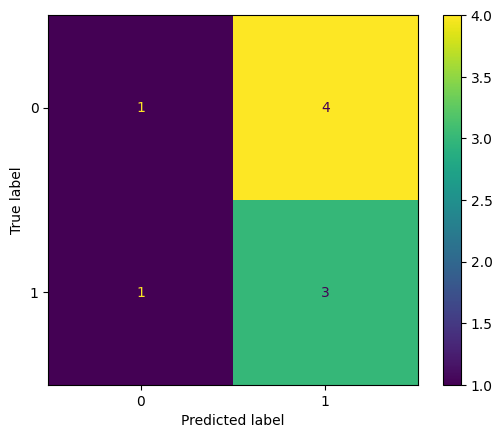

In [29]:
#Using RF

#This need tobe edited for we and  wi


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix#, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Referred to https://learn.microsoft.com/en-us/previous-versions/windows/desktop/bb226812(v=vs.85) to construct representative log messages.
messages = ["Unused variable 'unused_variable", "This function is deprecated, use new_function instead","Near memory limit", "Program crashed when loading file", "Division by zero is undefined", "Unused import 'unused_function'", "File Transfer Complete", "File loaded", "missing parentheses in call to 'example_function'"]
#The codding for the log messages is: {INFO: 0, Warn:1}.
true_labels = [0,0,1,1,0,0,1,1,0]

#Feature extraction using TF-IDF
message_Vect = tfidf_vectorizer.transform(messages)
print('done')
predicted_labels = best_model.predict(message_Vect)
predicted_lables_bin = []
for i in predicted_labels:
    if i=='info':
        predicted_lables_bin.append(1)
    else:
        predicted_lables_bin.append(0)

print('done')
#Calculates accuracy
accuracy = accuracy_score(true_labels,predicted_lables_bin)
print(predicted_labels)
#Calculate precision, recall, and F1 score
precision = precision_score(true_labels,predicted_lables_bin)
recall = recall_score(true_labels, predicted_lables_bin)
f1 = f1_score(true_labels, predicted_lables_bin)

#Calculate confusion matrix
confusion = confusion_matrix(true_labels, predicted_lables_bin)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(confusion)

import matplotlib.pyplot as plt
cm = confusion_matrix(true_labels, predicted_lables_bin)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
cmd_obj.plot()

plt.show()

## **Model: SVM**

In [30]:
from sklearn.svm import SVC

In [31]:
# Define the hyperparameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 25],
    'gamma': ['scale', 'auto', 0.1, 1, 10]
}

In [32]:
model1 = SVC(probability=True)
grid_search = GridSearchCV(estimator=model1, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_resampled, y_resampled)
# Get the best parameters from the grid search
best_params = grid_search.best_params_

#model.fit(X_resampled, y_resampled)
#model1.fit(X_train, y_train)

In [33]:
# Train the model with the best hyperparameters
best_model1 = SVC(probability=True,**best_params)
best_model1.fit(X_resampled, y_resampled)

SVC(C=1, probability=True)

Validation Set Results:
Accuracy: 0.835509138381201
MCC: 0.6703896668102232
Confusion Matrix:
 [[339  59]
 [ 67 301]]
              precision    recall  f1-score   support

        info       0.83      0.85      0.84       398
        warn       0.84      0.82      0.83       368

    accuracy                           0.84       766
   macro avg       0.84      0.83      0.84       766
weighted avg       0.84      0.84      0.84       766



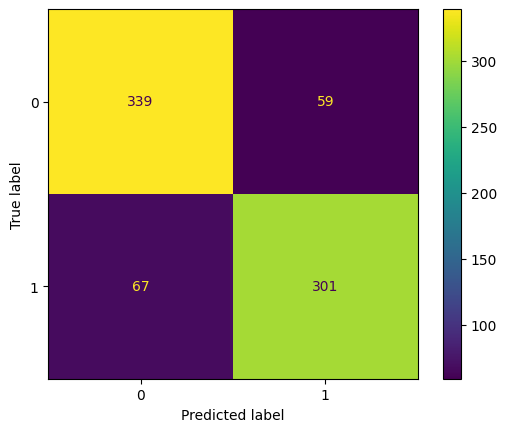

In [34]:
# Evaluate the SVM model on the validation set
y_val_pred = best_model1.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
mcc_val = matthews_corrcoef(y_val, y_val_pred)
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
report_val = classification_report(y_val, y_val_pred)

print("Validation Set Results:")
print(f"Accuracy: {accuracy_val}")
print(f"MCC: {mcc_val}")
print("Confusion Matrix:\n", conf_matrix_val)
print(report_val)


import matplotlib.pyplot as plt
cm = confusion_matrix(y_val, y_val_pred)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
cmd_obj.plot()

plt.show()

Test Set Results:
Accuracy: 0.8211488250652742
MCC: 0.6412598368347469
Confusion Matrix:
 [[342  60]
 [ 77 287]]
              precision    recall  f1-score   support

        info       0.82      0.85      0.83       402
        warn       0.83      0.79      0.81       364

    accuracy                           0.82       766
   macro avg       0.82      0.82      0.82       766
weighted avg       0.82      0.82      0.82       766



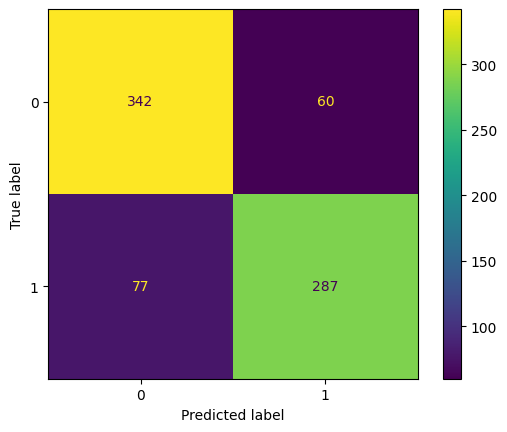

In [35]:
# Evaluate the SVM model on the test set
y_test_pred = best_model1.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
report_test = classification_report(y_test, y_test_pred)

print("Test Set Results:")
print(f"Accuracy: {accuracy_test}")
print(f"MCC: {mcc_test}")
print("Confusion Matrix:\n", conf_matrix_test)
print(report_test)

import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_test_pred)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
cmd_obj.plot()

plt.show()

In [36]:
print("\nSVM Model Results:")
y_svm_pred = best_model1.predict(X_test)
incorrect_svm_indices = y_test != y_svm_pred
correct_svm_indices = y_test == y_svm_pred


SVM Model Results:


In [37]:
incorrect_svm_texts = df1.loc[y_test.index[incorrect_svm_indices], 'preprocessed_text']
true_svm_labels = y_test[incorrect_svm_indices]
predicted_svm_labels = y_svm_pred[incorrect_svm_indices]

print("\nRecords where svm model failed to predict the labels:")
for idx, text, true_label, pred_label in zip(incorrect_svm_texts.index, incorrect_svm_texts, true_svm_labels, predicted_svm_labels):
    #print(f"Index: {idx}, Text: {text}, True Label: {true_label}, Predicted Label: {pred_label}")
    print(f"Index: {idx}")
    print(f"True Labels: {true_label}")
    print(f"Predicted Labels: {pred_label}")
    print(f"Text: {text}\n")


Records where svm model failed to predict the labels:
Index: 2206
True Labels: info
Predicted Labels: warn
Text: fail delet

Index: 376
True Labels: warn
Predicted Labels: info
Text: server hold hbase meta right

Index: 5770
True Labels: info
Predicted Labels: warn
Text: fail creat channel due

Index: 1419
True Labels: warn
Predicted Labels: info
Text: procedur resubmit anoth thread reject request

Index: 2276
True Labels: warn
Predicted Labels: info
Text: hdf region dir alreadi sidelin

Index: 3106
True Labels: info
Predicted Labels: warn
Text: empti messag

Index: 3605
True Labels: warn
Predicted Labels: info
Text: clean activ sstabl

Index: 6824
True Labels: warn
Predicted Labels: info
Text: request next learner master longer valid

Index: 199
True Labels: warn
Predicted Labels: info
Text: superior

Index: 3316
True Labels: warn
Predicted Labels: info
Text: attempt use nonexist

Index: 1400
True Labels: warn
Predicted Labels: info
Text: file link found

Index: 1193
True Labels: inf

In [38]:

correct_svm_texts = df1.loc[y_test.index[correct_svm_indices], 'preprocessed_text']
correct_true_svm_labels = y_test[correct_svm_indices]
correct_predicted_svm_labels = y_rf_pred[correct_svm_indices]

In [39]:
print("\nRecords where svm model failed to predict the labels:")
for idx, text, true_label, pred_label in zip(incorrect_svm_texts.index, incorrect_svm_texts, true_svm_labels, predicted_svm_labels):
   # print(f"Index: {idx}, Text: {text}, True Label: {true_label}, Predicted Label: {pred_label}")
    print(f"Index: {idx}")
    print(f"True Labels: {true_label}")
    print(f"Predicted Labels: {pred_label}")
    print(f"Text: {text}\n")


Records where svm model failed to predict the labels:
Index: 2206
True Labels: info
Predicted Labels: warn
Text: fail delet

Index: 376
True Labels: warn
Predicted Labels: info
Text: server hold hbase meta right

Index: 5770
True Labels: info
Predicted Labels: warn
Text: fail creat channel due

Index: 1419
True Labels: warn
Predicted Labels: info
Text: procedur resubmit anoth thread reject request

Index: 2276
True Labels: warn
Predicted Labels: info
Text: hdf region dir alreadi sidelin

Index: 3106
True Labels: info
Predicted Labels: warn
Text: empti messag

Index: 3605
True Labels: warn
Predicted Labels: info
Text: clean activ sstabl

Index: 6824
True Labels: warn
Predicted Labels: info
Text: request next learner master longer valid

Index: 199
True Labels: warn
Predicted Labels: info
Text: superior

Index: 3316
True Labels: warn
Predicted Labels: info
Text: attempt use nonexist

Index: 1400
True Labels: warn
Predicted Labels: info
Text: file link found

Index: 1193
True Labels: inf

done
done
['info' 'warn' 'warn' 'info' 'info' 'info' 'info' 'info' 'info']
Accuracy: 0.44
Precision: 0.43
Recall: 0.75
F1 Score: 0.55
Confusion Matrix:
[[1 4]
 [1 3]]


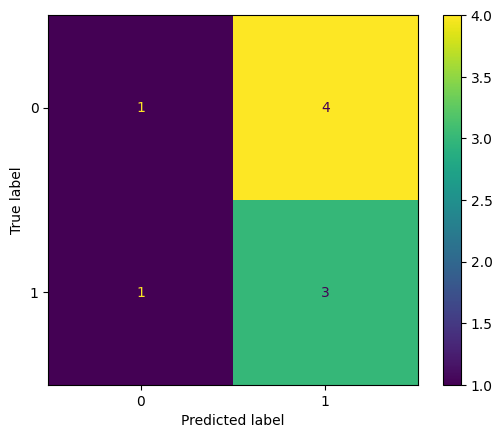

In [40]:
# Using SVM


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix#, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Referred to https://learn.microsoft.com/en-us/previous-versions/windows/desktop/bb226812(v=vs.85) to construct representative log messages.
messages = ["Unused variable 'unused_variable", "This function is deprecated, use new_function instead","Near memory limit", "Program crashed when loading file", "Division by zero is undefined", "Unused import 'unused_function'", "File Transfer Complete", "File loaded", "missing parentheses in call to 'example_function'"]
#The codding for the log messages is: {INFO: 0, Warn:1}.
true_labels = [0,0,1,1,0,0,1,1,0]

#Feature extraction using TF-IDF
message_Vect = tfidf_vectorizer.transform(messages)
print('done')
predicted_labels = best_model1.predict(message_Vect)
predicted_lables_bin = []
for i in predicted_labels:
    if i=='info':
        predicted_lables_bin.append(1)
    else:
        predicted_lables_bin.append(0)

print('done')
#Calculates accuracy
accuracy = accuracy_score(true_labels,predicted_lables_bin)
print(predicted_labels)
#Calculate precision, recall, and F1 score
precision = precision_score(true_labels,predicted_lables_bin)
recall = recall_score(true_labels, predicted_lables_bin)
f1 = f1_score(true_labels, predicted_lables_bin)

#Calculate confusion matrix
confusion = confusion_matrix(true_labels, predicted_lables_bin)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(confusion)

import matplotlib.pyplot as plt
cm = confusion_matrix(true_labels, predicted_lables_bin)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
cmd_obj.plot()

plt.show()